In [415]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке. Если в итоге по каким-то причинам тетрадка не будет открываться у преподавателя, задание не будет засчитано
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [416]:
#!pip install gdown

In [ ]:
!gdown 18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0 -O data.csv

In [418]:
df = pd.read_csv('data.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [419]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

In [420]:
df.shape

(8547, 7)

In [421]:
df.sample()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
2174,Barbie,£7.75,20 new,1,1.0,5.0 out of 5 stars,Characters & Brands > Barbie > Barbie Dolls & ...


## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

In [422]:
total_nans_sum = df.isnull().sum().sum()
total_data = df.size
total_nans_sum

3469

In [423]:
print(f'NaN/all_data = {round(total_nans_sum/total_data, 3)}')

NaN/all_data = 0.058


Пропуски есть, их достаточно много, надо посмотреть на них под лупой.

In [424]:
df.isnull().sum()

manufacturer                           5
price                                  0
number_available_in_stock           2211
number_of_reviews                     15
number_of_answered_questions         673
average_review_rating                 15
amazon_category_and_sub_category     550
dtype: int64

number_available_in_stock - в глаза бросается эта фича. У четверти данных у нас отсутствует данная информация, думаю, не очень это и влияет. Думаю, можно удалить данную фичу. Но к выводам приду чуть попозже, когда проанализирую тщательнее        

Посмотрю на пропуски внутри строки. Хочу посмотреть, а в скольких у нас строках отсутствуют данные по фичам. Если отсутствует половина фич - это вообще не очень хорошо.

In [425]:
null_rows = df.isnull().sum(axis=1)
data = null_rows.groupby(null_rows).count()
pd.DataFrame({'Quantity NaN in row': [i for i in range(len(data))], 'NaNs': data})

,Quantity NaN in row,NaNs
0,0,5486
1,1,2668
2,2,379
3,3,13
4,4,1


У нас всего 7 колонок(фич), думаю, стоит удалить те, у которых > 3 пропусков. Их вообще немного, но зато наша моделька меньше путаться будет.

In [426]:
df = df[df.isna().sum(axis=1) < 3]

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

In [427]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8533 entries, 0 to 8546
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   manufacturer                      8529 non-null   object 
 1   price                             8533 non-null   object 
 2   number_available_in_stock         6332 non-null   object 
 3   number_of_reviews                 8523 non-null   object 
 4   number_of_answered_questions      7868 non-null   float64
 5   average_review_rating             8523 non-null   object 
 6   amazon_category_and_sub_category  7997 non-null   object 
dtypes: float64(1), object(6)
memory usage: 533.3+ KB


In [428]:
df.sample()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
6268,Brookite,£15.80,6 new,11,1.0,4.7 out of 5 stars,Fancy Dress > Costumes


Первая колонка - мануфактура. С ней всё ок, ничего и не придумаешь.\
Вторая колонка - price. Она мне не нравится, имеет строковый тип данных. Надо сделать его вещественным.

In [429]:
def convert_strprice_floatprice(price):
    price = price.replace(',', '') ## Для того, чтобы тысячи разделять
    return float(price[1:])
    
df.price = df.price.apply(lambda price: convert_strprice_floatprice(price))

In [430]:
df.sample()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
7875,Unbekannt,5.35,3 new,164,1.0,4.2 out of 5 stars,Games > Educational Games


In [431]:
fig_price = px.histogram(df,
                        x='price',
                        marginal='box')

fig_price.update_layout(
    title="Распределение цен",
    title_x = 0.5,
    xaxis_title="Цена",
    yaxis_title="Количество")

75% процентов данных у нас содержатся в прайсе < 20, и на 95% меньше чем 50. Надо посмотреть, что там у нас у самых дорогих книжек

In [ ]:
df.number_available_in_stock.unique()

Здесь я вижу, что эту фичу можно разделить на две. На количество товара и степень его "использованности". Делаем. И nan заменим на 0. Логично, что эт означает, что нет в наличии ничего.

In [433]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

In [434]:
df.number_available_in_stock = df.number_available_in_stock.fillna(0)

In [435]:
def split_Quantity_Quality(stock):
    try:
        stock = stock.split('\xa0')
        return int(stock[0]), stock[1]
    except:
        return 0, 'absence'

df_stock = df.number_available_in_stock.apply(lambda stock : split_Quantity_Quality(stock))

df['quanity'] = df_stock.apply(lambda x: x[0])
df['quality'] = df_stock.apply(lambda x: x[1])
df = df.drop(columns='number_available_in_stock')

In [437]:
px.scatter(df, y='price', x='quanity')

Не вижу приятных вещей, что грустно.

number_of_reviews, number_of_answered_questions - много пропусков, заполним медианным значением, почему бы и нет. Но они у нас строка/float. Предварительно переведу их int'ам. Но приведу медианные значения я вставлю попозже, в после разбития на train и test. Чтобы не происходила утечка данных.

In [438]:
def convert_str_int(number_of_reviews):
    try:
        number_of_reviews = number_of_reviews.replace(',', '')
        return int(number_of_reviews)
    except:
        return None

df.number_of_reviews = df.number_of_reviews.apply(lambda number: convert_str_int(number))

average_review_rating - разобью его чисто на float. Зачем мне знать, сколько там из 5 звезд. Просто оставлю, сколько.

In [439]:
def convert_str_float(stars):
    try:
        return float(stars.split()[0])
    except:
        return None


df.average_review_rating = df.average_review_rating.apply(lambda stars: convert_str_float(stars))

Проверим, что у нас по заполняемости. Посмотрим, всё ли ок.

In [440]:
df.isnull().sum()

manufacturer                          4
price                                 0
number_of_reviews                    10
number_of_answered_questions        665
average_review_rating                10
amazon_category_and_sub_category    536
quanity                               0
quality                               0
dtype: int64

Ну здесь у нас производитель в 4х товарах не известен. Это капля в море, можем себе позволить удалить.

In [441]:
df = df.dropna(subset=['manufacturer'])

Посмотрим на промежуточный результат. В принципе, диаграммы говорят сами за себя.

In [442]:
fig_comparison = px.scatter_matrix(df,
            dimensions=['price', 'number_of_reviews', 'number_of_answered_questions']) 
fig_comparison.show()

In [443]:
fig_comparison = px.scatter_matrix(df,
            dimensions=['price','average_review_rating', 'manufacturer']) 
fig_comparison.show()

In [552]:
fig_comparison = px.scatter_matrix(df,
            dimensions=['price','quanity', 'quality', 'manufacturer']) 
fig_comparison.show()

Составив матрицу, многое стает понятным. Есть у нас бренды, которые пользуется спросом, а есть те, которые "количеством"))

Теперь осталось посмотреть последнюю колонку - категории. Давайте их разобьем, посмотрим, сколько всего категорий может быть в одном товаре, сколько в среднем, посмотрим, как там после разбиения они себя вести будут.

In [445]:
def split_categories(categories):
    try:
        categories = categories.split('>')
        categories = [category.strip() for category in categories]
        return len(categories), categories
    except:
        return 0, 'miss'

df_category = df.amazon_category_and_sub_category.apply(lambda categories: split_categories(categories))
df_category.apply(lambda x: x[0]).describe()

count    8529.000000
mean        2.578966
std         0.970306
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: amazon_category_and_sub_category, dtype: float64

Всего у нас существует 5 подкатегорий. Предлагаю добавить 5 новых колонок, где в каждой колонке планируется его соответствующая подкатегория. С учетом этого отредактирую функцию сплита

In [446]:
def split_categories(categories):
    try:
        categories = categories.split('>')
        categories = [category.strip().lower() for category in categories]
        if len(categories) < 5:
            return categories + (5 - len(categories)) * ['miss']
        return categories
    except:
        return ['miss'] * 5

df_category = df.amazon_category_and_sub_category.apply(lambda categories: split_categories(categories))

In [ ]:
for i in range(5):
    df[f'category_{i}'] = df_category.apply(lambda x: x[i])

Удалю колонку, которая служила для сплитом.

In [448]:
df = df.drop(columns='amazon_category_and_sub_category')

Сделаю красивее производителей.

In [449]:
df.manufacturer = df.manufacturer.apply(lambda name: name.lower())

In [450]:
df.quality.value_counts()

new            6262
absence        2201
used             58
collectible       7
refurbished       1
Name: quality, dtype: int64


У меня получилось всего 3 категориальных признака. Производитель, Качество, Категории
Ответ на доп.вопросы:
- Через ординал я бы сделал категории, наверное. Или же производителя. Но тогда модель может начать искать зависимости между числами, а не признаками. Сейчас попробую на опыте выяснить, что лучше
- one-hot декодинг я бы использовал в колонке quality, там всего 5 разновидностей, прибавилось бы 5 фич. Остальные - слишком многочисленные категориальные переменные, у нас получится > 2к фич и это уже чересчур сильно усложнит модель. 

Это красиво.

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [467]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=['price']), df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Теперь стоит заполнить наконец наши NaN. Давайте вспомним, какие у нас там NaN остались после обработки. И какие типы данных у объектов

Заполним медианой количество отзывов. И приведем к нормальному типу

In [ ]:
def fill_nan(X, type='int64'):
    median = X.median()
    X = X.fillna(median)
    if type == 'int64':
        X = X.astype(type)
        return X
    return X

X_train.number_of_reviews = fill_nan(X_train.number_of_reviews)
X_test.number_of_reviews = fill_nan(X_test.number_of_reviews)

Заполним медианой количество отвеченных вопросов. И приведем к нормальному типу

In [469]:
X_train.number_of_answered_questions = fill_nan(X_train.number_of_answered_questions)
X_test.number_of_answered_questions = fill_nan(X_test.number_of_answered_questions)

И средний рейтинг тоже медианой бахнем

In [471]:
X_train.average_review_rating = fill_nan(X_train.average_review_rating)
X_test.average_review_rating = fill_nan(X_test.average_review_rating)

Проверим, всё ли ок

In [472]:
X_train.isnull().sum()

manufacturer                    0
number_of_reviews               0
number_of_answered_questions    0
average_review_rating           0
quanity                         0
quality                         0
category_0                      0
category_1                      0
category_2                      0
category_3                      0
category_4                      0
dtype: int64

In [473]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5970 entries, 3136 to 4650
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   manufacturer                  5970 non-null   object 
 1   number_of_reviews             5970 non-null   int64  
 2   number_of_answered_questions  5970 non-null   int64  
 3   average_review_rating         5970 non-null   float64
 4   quanity                       5970 non-null   int64  
 5   quality                       5970 non-null   object 
 6   category_0                    5970 non-null   object 
 7   category_1                    5970 non-null   object 
 8   category_2                    5970 non-null   object 
 9   category_3                    5970 non-null   object 
 10  category_4                    5970 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 559.7+ KB


Всё ок)

In [474]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

trans = ColumnTransformer(
    [('num', StandardScaler(with_mean=False), [1,2,3,4]),
     ('cat', OneHotEncoder(handle_unknown='ignore'), [5])])

X_train= trans.fit_transform(X_train)
X_test = trans.transform(X_test)

dummy = DummyRegressor()
dummy.fit(X_train, y_train)

DummyRegressor()

In [475]:
from sklearn.metrics import mean_squared_error as mse, r2_score

y_pred = dummy.predict(X_test)
print("MSE: ", mse(y_test, y_pred))
print("RMSE: ", mse(y_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_test, y_pred))

MSE:  1189.6258130362603
RMSE:  34.49095262581566
r2_score:  -0.001325621417417544


## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [476]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse

In [477]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [478]:
print("MSE: ", mse(y_test, y_pred))
print("RMSE: ", mse(y_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_test, y_pred))

MSE:  1525.2824066880085
RMSE:  39.05486405926935
r2_score:  -0.28385273501741937


Качество ухудшилось в сравнении с Dummy моделью. Но в целом очень даже ничего.

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [462]:
from sklearn.linear_model import LinearRegression

In [481]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

print("MSE: ", mse(y_test, y_pred))
print("RMSE: ", mse(y_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_test, y_pred))

MSE:  1201.3573679801439
RMSE:  34.6606025334261
r2_score:  -0.011200244526338388


В моем случае работает лучше дерева, но хуже Dummy-модели.

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [492]:
import seaborn as sns


def plot_fitting_curve(parameter: str, values: list, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        model = DecisionTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve, label='train')
    sns.lineplot(x=values, y=test_curve, label='test')

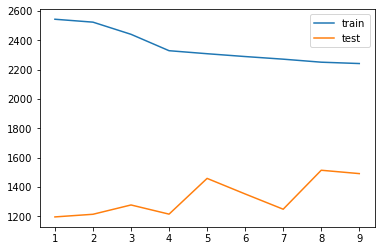

In [509]:
plot_fitting_curve('max_depth', np.arange(1, 10), X_train, X_test, y_train, y_test)

Глубина 4 однозначно самый хороший параметр, дальше нашу модель сильно колбасит

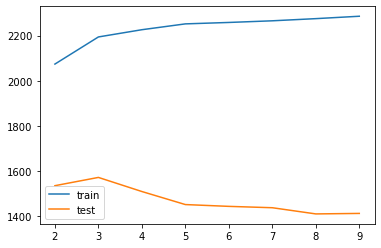

In [502]:
plot_fitting_curve('min_samples_split', np.arange(2, 10), X_train, X_test, y_train, y_test)

Тут 5.

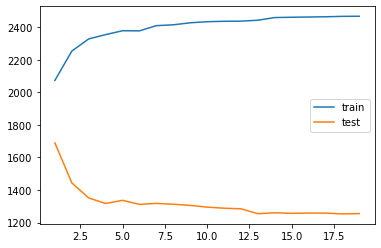

In [506]:
plot_fitting_curve('min_samples_leaf', np.arange(1, 20, 1), X_train, X_test, y_train, y_test)

Думаю, что здесь 4

In [551]:
tree_par = DecisionTreeRegressor(max_depth=3, min_samples_split=5, min_samples_leaf=4)
tree_par.fit(X_train, y_train)
y_pred = tree_par.predict(X_test)
print("MSE: ", mse(y_test, y_pred))
print("RMSE: ", mse(y_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_test, y_pred))

MSE:  1232.3118382635585
RMSE:  35.104299427043955
r2_score:  -0.037255079460592144


Стало гораздо лучше)

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [523]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]

    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

In [525]:
ens_tree = EnsembleTreeRegressor()
ens_tree.fit(X_train, y_train)
y_pred = ens_tree.predict(X_test)

print("MSE: ", mse(y_test, y_pred))
print("RMSE: ", mse(y_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_test, y_pred))

MSE:  1523.7548632261903
RMSE:  39.035302781279796
r2_score:  -0.28256697911889606


Чутка лучше, изменения незначительны

In [ ]:
def plot_fitting_curve_ens(parameter: str, values: list, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        model = EnsembleTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve, color='r', legend='brief', label='train')
    sns.lineplot(x=values, y=test_curve, color='g', legend='brief', label='test')

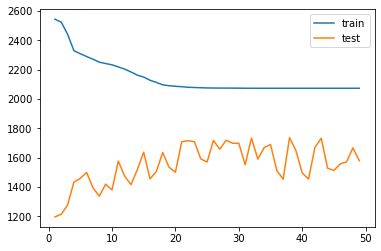

In [527]:
plot_fitting_curve('max_depth', np.arange(1, 50), X_train, X_test, y_train, y_test)

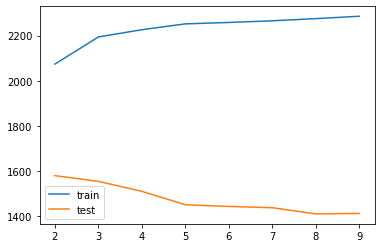

In [528]:
plot_fitting_curve('min_samples_split', np.arange(2, 10), X_train, X_test, y_train, y_test)

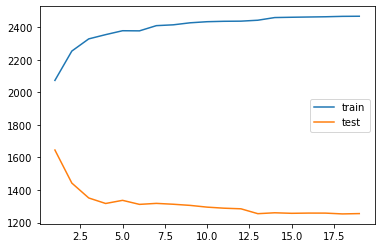

In [529]:
plot_fitting_curve('min_samples_leaf', np.arange(1, 20, 1), X_train, X_test, y_train, y_test)

троечка.

In [545]:
ens_tree_par = DecisionTreeRegressor(max_depth=1, min_samples_split=10, min_samples_leaf=15)
ens_tree_par.fit(X_train, y_train)
y_pred = ens_tree_par.predict(X_test)

print("MSE: ", mse(y_test, y_pred))
print("RMSE: ", mse(y_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_test, y_pred))

MSE:  1196.6028177486317
RMSE:  34.59194729628027
r2_score:  -0.007198269356534226
